In [2]:
include("goddard_hermite-Simpson.jl")
include("goddard.jl")
include("goddard_Euler.jl")
using NLPModels
using NLPModelsIpopt
using NLPModelsJuMP
using SparseArrays
using SuiteSparse
using Plots
using LinearAlgebra

function normalize_matrix(mat)
    min_val = minimum(mat)
    max_val = maximum(mat)
    return (mat .- min_val) ./ (max_val - min_val)
end

function present_Heatmap(Mat,name="")
    # norm_matrix = normalize_matrix(Mat)
    max_Mat = round(maximum(Mat),sigdigits = 4)
    min_Mat = round(minimum(Mat),sigdigits = 4)
    Lims = "[$min_Mat,$max_Mat]"
    p = heatmap(norm_matrix, color=:grays, 
            xlabel="Columns", ylabel="Rows", title="Matrix Heatmap of H $name")
    #Plots.savefig(p,"$name,$Lims.png")
    return p
end

function Calcul_H_model(goddard_model,nh=100)
    model = goddard_model(nh)
    nlp = MathOptNLPModel(model)
    res = ipopt(nlp)
    x = res.solution
    y = res.multipliers
    n = NLPModels.get_nvar(nlp)
    m = NLPModels.get_ncon(nlp)
    
    nnzh = NLPModels.get_nnzh(nlp)
    Wi, Wj = NLPModels.hess_structure(nlp)
    Wz = zeros(nnzh)
    NLPModels.hess_coord!(nlp, x, y, Wz)
    W = sparse(Wi, Wj, Wz, n, n)

    nnzj = NLPModels.get_nnzj(nlp)
    Ji, Jj = NLPModels.jac_structure(nlp)
    Jz = zeros(nnzj)
    NLPModels.jac_coord!(nlp, x, Jz)
    J = sparse(Ji, Jj, Jz, m, n)

    j1 = Matrix(J)
    Z = nullspace(j1)
    H = Z'*Symmetric(W, :L)*Z    
    # present_Heatmap(H,name_model)

    return H
end

Calcul_H_model (generic function with 2 methods)

In [3]:
Deltas = [1e-5,5e-5,1e-4,5e-4,0.001,0.005]
nhs = (1 ./ Deltas ) .^(0.5)
nhs

6-element Vector{Float64}:
 316.2277660168379
 141.4213562373095
 100.0
  44.721359549995796
  31.622776601683793
  14.142135623730951

In [4]:
nhs = [10,50,100,150,200,250,300]

function plot_Hmax_nhs(nhs)
    Maxs = zeros(length(nhs))
    D_car = (1 ./ nhs ) .^2
    for i in range(1,length(nhs))
        print(nhs[i])
        H_nh = Calcul_H_model(rocket_model_euler_exp,nhs[i])
        Max_nh = maximum(H_nh)
        Maxs[i] = Max_nh
    end
    Plots.scatter(D_car,Maxs,xlabel = "Delta Carre", ylabel = "Max(H)")
    Plots.plot!([D_car[1],D_car[end]],[Maxs[1],Maxs[end]])
    return(Maxs)
end

Maxs = plot_Hmax_nhs(nhs)

10
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      144
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      397

Total number of variables............................:       45
                     variables with only lower bounds:       23
                variables with lower and upper bounds:       22
                     variables with only upper bounds:        0
Total number of equality constraints.................:       34
Total number of inequality

7-element Vector{Float64}:
 0.0004637449292069904
 4.787010762161914e-5
 1.4916883152941398e-5
 6.208531843641525e-6
 2.9342204391371867e-6
 1.924693259632334e-6
 1.4279843351774536e-6

In [25]:
nh = 200
model = rocket_model(nh)
nlp = MathOptNLPModel(model)
res = ipopt(nlp)
x = res.solution
y = res.multipliers
n = NLPModels.get_nvar(nlp)
m = NLPModels.get_ncon(nlp)

nnzh = NLPModels.get_nnzh(nlp)
Wi, Wj = NLPModels.hess_structure(nlp)
Wz = zeros(nnzh)
NLPModels.hess_coord!(nlp, x, y, Wz)
W = sparse(Wi, Wj, Wz, n, n)

nnzj = NLPModels.get_nnzj(nlp)
Ji, Jj = NLPModels.jac_structure(nlp)
Jz = zeros(nnzj)
NLPModels.jac_coord!(nlp, x, Jz)
J = sparse(Ji, Jj, Jz, m, n)

j1 = Matrix(J)
Z = nullspace(j1)
H = Z'*Symmetric(W, :L)*Z   
Z

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3804
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9800

Total number of variables............................:      805
                     variables with only lower bounds:      403
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      604
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.68e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

805×201 Matrix{Float64}:
  0.0          0.0          0.0         …   0.0           0.0
  2.36106e-7  -1.3192e-8   -1.31604e-8     -4.76181e-9    2.53821e-7
  9.46162e-7   1.98845e-7  -5.19962e-8     -2.05391e-8    7.7103e-7
  1.88303e-6   8.88219e-7   1.36562e-7     -4.88796e-8    1.30696e-6
  2.79703e-6   1.80464e-6   8.05078e-7     -8.98749e-8    1.86066e-6
  3.68654e-6   2.69652e-6   1.70096e-6  …  -1.43577e-7    2.43075e-6
  4.55004e-6   3.56235e-6   2.57074e-6     -2.10002e-7    3.01566e-6
  5.38615e-6   4.4007e-6    3.41297e-6     -2.89131e-7    3.61418e-6
  6.19357e-6   5.21027e-6   4.22635e-6     -3.80913e-7    4.22534e-6
  6.97117e-6   5.98992e-6   5.00969e-6     -4.85271e-7    4.84798e-6
  ⋮                                     ⋱                 ⋮
  6.97536e-5   6.92747e-5   6.25454e-5     -0.000203031  -0.0123505
  6.31353e-5   6.24569e-5   5.58709e-5     -0.000199061  -0.0122336
  5.76052e-5   5.67044e-5   5.01397e-5     -0.00019196   -0.0122683
  5.61938e-5   5.53277e-5   4

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

304

In [ ]:
include("goddard.jl")
ts = zeros(6)
i = 1
for nh in [10,50,100,500,1000,2000]
    nh = 1000
    model = rocket_model_euler_imp(nh)
    JuMP.set_optimizer(model, Ipopt.Optimizer)
    JuMP.set_attribute(model,"tol",1e-8)
    JuMP.set_attribute(model, "hsllib", HSL_jll.libhsl_path)
    JuMP.set_attribute(model, "linear_solver", "ma57")
    JuMP.optimize!(model)
    ts[i] = value(model[:step])*nh
    i = i+1
end
ts

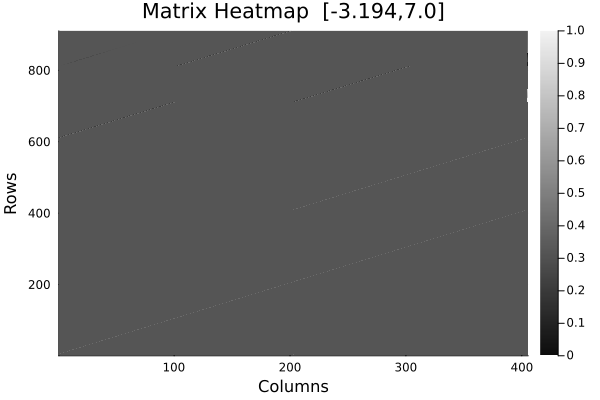

In [4]:
# Get primal-dual solution
x = res.solution
y = res.multipliers

n = NLPModels.get_nvar(nlp)
m = NLPModels.get_ncon(nlp)

# Build sparse Hessian 
nnzh = NLPModels.get_nnzh(nlp)
Wi, Wj = NLPModels.hess_structure(nlp)
Wz = zeros(nnzh)
NLPModels.hess_coord!(nlp, x, y, Wz)
W = sparse(Wi, Wj, Wz, n, n)

# Build sparse Jacobian 
nnzj = NLPModels.get_nnzj(nlp)
Ji, Jj = NLPModels.jac_structure(nlp)
Jz = zeros(nnzj)
NLPModels.jac_coord!(nlp, x, Jz)
J = sparse(Ji, Jj, Jz, m, n)

l = NLPModels.get_lvar(nlp)
u = NLPModels.get_uvar(nlp)

tol = 1e-7
Al = findall(res.multipliers_L .> tol)
Au = findall(res.multipliers_U .> tol)

nl = length(Al)
nu = length(Au)

Jact = sparse([Ji; m+1:m+nl; m+nl+1:m+nl+nu], [Jj; Al; Au], [Jz; ones(nl); ones(nu)], m+nl+nu, n)

present_Heatmap(Jact)

In [7]:
J

910×405 SparseMatrixCSC{Float64, Int64} with 2510 stored entries:
⎡⠳⣄⠀⠀⠈⠀⠀⠀⠈⠀⠀⠀⠈⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢢⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠙⢦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡄⠀⎥
⎢⠲⡄⠀⠀⠰⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⎥
⎢⠀⠙⢦⡀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⎥
⎢⠀⠀⠀⠙⠆⠀⠀⠈⠳⣄⠀⠀⠠⣄⠀⠀⠀⡇⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠈⠳⣄⠀⡇⎥
⎢⣄⠀⠀⠀⢠⡀⠀⠀⢠⡀⠀⠈⠳⣄⠀⠈⠳⡇⎥
⎢⠈⠳⣄⠀⠀⠙⢦⠀⠀⠙⢦⡀⠀⠈⠳⡄⠀⡇⎥
⎣⠀⠀⠈⠳⡄⠀⠈⠳⣄⠀⠀⠙⢦⠀⠀⠙⢦⡇⎦

In [6]:
W

405×405 SparseMatrixCSC{Float64, Int64} with 3015 stored entries:
⎡⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎣⣀⣀⣀⣀⣀⣀⣀⣀⣙⣦⣀⣀⣀⣀⣀⣀⣀⣀⣙⣦⣀⣀⣀⣀⣀⣀⣀⣀⣙⣦⣀⣀⣀⣀⣀⣀⣀⣈⣳⣄⎦

In [20]:
using LinearAlgebra
Jact1 = Matrix(Jact)
Z = nullspace(Jact1)

405×0 Matrix{Float64}

In [21]:
H = Z'*Symmetric(W, :L)*Z
present_Heatmap(H,"H")

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [22]:
J* Z

910×0 Matrix{Float64}

In [23]:
eigvals(H)

Float64[]

In [1]:
function Ass()
    return ([123,1,2,2],1)
end

Ass (generic function with 1 method)

In [3]:
Ass()[2]

1